# Setup

## Imports

In [2]:
import csv
import time
import os.path
import datetime
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()
import csv
import itertools
from scipy.stats import gaussian_kde
import math
import inspect
import graphviz
import pickle
import plotly.graph_objects as go
import pprint
import random
from tqdm.notebook import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.cluster.hierarchy import dendrogram
from sklearn.ensemble import BaggingClassifier
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFE
import joblib
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, classification_report, matthews_corrcoef
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.ensemble._forest import _get_n_samples_bootstrap
from sklearn.ensemble._forest import _generate_sample_indices
from sklearn import tree

In [3]:
pd.options.mode.chained_assignment = None

## Functions

In [4]:
def predict_proba_daily_recal(model, X_train, y_train, X_test, y_test):
    """Output of model.predict_proba() but with daily recalibration"""
    test_dates = pd.to_datetime(X_test.index.str[:10], format="%d/%m/%Y")
    distinct_dates = test_dates.unique()
    y_probs_list =  []
    
    for date in tqdm(distinct_dates):
        # For every day in the test set, we add all past days to the training set
        X_train_new = pd.concat([X_train, X_test[test_dates < date]])
        y_train_new = pd.concat([y_train, y_test[test_dates < date]])
        # And we create a sub test set composed of that day only
        X_test_new = X_test[test_dates == date]
        y_test_new = y_test[test_dates == date]

        model.fit(X_train_new, y_train_new)
        
        y_probs = model.predict_proba(X_test_new)

        y_pred_new = (y_probs[:,1] >= 0.3).astype(bool) # Hard coded probability threshold that was optimised later in the notebook
        
        print("F1-score for day {} is {}".format(date, f1_score(y_test_new, y_pred_new)))
        print(confusion_matrix(y_test_new, y_pred_new))
        print("\n")
        y_probs_list.append(y_probs)
    
    return np.concatenate(y_probs_list, axis=0)

In [5]:
# CONSFUSION MATRIX
def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [6]:
def find_best_prob_threshold(clf, X, y):
    """Find best probability threshold given a fitted classifier, a set of covariates X and a response y"""
    f1 = []
    pred_probs = clf.predict_proba(X)[:,1]
    for prob_thre in range(1,100):      
        y_pred = (pred_probs >= prob_thre / 100).astype(bool)
        f1.append(f1_score(y, y_pred))
    max_f1 = max(f1)
    argmax_f1 = f1.index(max_f1) / 100
    return max_f1, argmax_f1

In [7]:
def test_clf_CV(clf, X, y):
    """Test classifier with leave-one-month-out cross validation"""
    accuracy = []
    precision = []
    recall = []
    f1 = []
    threshold = []
    
    for month in trange(1, 12):
        
        train_X = X[X.index.str[3:5].astype(int) != month]
        test_X = X[X.index.str[3:5].astype(int) == month]
        train_y =  y[X.index.str[3:5].astype(int) != month]
        test_y =  y[X.index.str[3:5].astype(int) == month]
        print(f"Fitting leaving month {month} out...")
        clf.fit(train_X, train_y)
        
        _, thresh = find_best_prob_threshold(clf, test_X, test_y)
        threshold.append(thresh)
        print("Best threshold found is: {:.2f}".format(thresh))
        y_pred = clf.predict_proba(test_X)[:,1] > thresh
    
        accuracy.append(accuracy_score(test_y, y_pred))
        precision.append(precision_score(test_y, y_pred))
        recall.append(recall_score(test_y, y_pred))
        f1.append(f1_score(test_y, y_pred))
        
        print("Accuracy score is: {:.3f}".format(accuracy[-1]))
        print("Precision score is: {:.3f}".format(precision[-1]))
        print("Recall score is: {:.3f}".format(recall[-1]))
        print("F1 score is: {:.3f}\n".format(f1[-1]))

    score_df = pd.DataFrame({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'threshold': threshold
    }, index=range(1,12))

    return score_df

# Main

In [8]:
DBorig = pickle.load(open('DBup_2019.pickle', "rb"))
DBorig = DBorig[DBorig.Tech!='UVAM']
DB = DBorig.copy()
#DB = DB.sample(n=100000)
DB['Result'].value_counts() # check su % accettati su totale

#DB = pickle.load(open('DBup_2019.pickle', "rb"))

Result
0.0    748123
1       27747
Name: count, dtype: int64

In [9]:
DB["date"] = pd.to_datetime(DB.index.str[:10], format="%d/%m/%Y")
DB.sort_values("date", inplace=True)
DB.drop(["date", "Target"], axis=1, inplace=True)

In [10]:
# We first of all create a test "hold-out" dataset corresponding to the last month, that we don't consider until the very end evaluation
test_DB = DB[DB.index.str[3:5] == '12']
DB = DB[DB.index.str[3:5] != '12']
test_DB.head(3)

hour    SC_PC1   SC_PC2    IN_PC1    IN_PC2  \
idx                                                                      
01/12/201916UP_RIVADEL_3     16  1.273358  0.16032 -1.233172  0.217088   
01/12/201916UP_OSTIGLIA_3    16  1.273358  0.16032 -1.233172  0.217088   
01/12/201916UP_OSTIGLIA_12   16  1.273358  0.16032 -1.233172  0.217088   

                              CT_PC1    CT_PC2   PurchMGP    SellMGP MargTech  \
idx                                                                             
01/12/201916UP_RIVADEL_3   -1.609601  0.538882  15263.037  12092.322       MC   
01/12/201916UP_OSTIGLIA_3  -1.609601  0.538882  15263.037  12092.322       MC   
01/12/201916UP_OSTIGLIA_12 -1.609601  0.538882  15263.037  12092.322       MC   

                           GNprice SolarAngle  DeclAngle  WorkDay     Prov  \
idx                                                                          
01/12/201916UP_RIVADEL_3    16.372  50.195217 -22.107749  holiday   Trento   
01/12/201916UP_OSTIGLIA_3   16.372  50.195217 -22.107749  holiday  Mantova   
01/12/201916UP_OSTIGLIA_12  16.372  50.195217 -22.107749  holiday  Mantova   

                                            Tech   PV  Price Result  
idx                                                                  
01/12/201916UP_RIVADEL_3    Hydro Pumped Storage  0.0   70.0    0.0  
01/12/201916UP_OSTIGLIA_3             Fossil Gas  0.0   88.0    0.0  
01/12/201916UP_OSTIGLIA_12            Fossil Gas  0.0  180.0    0.0

In [11]:
retrain_model = True;
#DB = pd.read_pickle('DB.pickle')

### 1) Building the classification model (encoding, scaling and training + hyperparameters optimisation)
### 2) Evaluate the model (accuracy, oob score, recall, precision, ROC AUC, confusion matrix)
### 3) Feature importance --> capire unità di misura dell'importanza


### 1) Classification Model ###

# features list
#["hour", "SC_PC1", "SC_PC2", "IN_PC2", "IN_PC2","CT_PC1","CT_PC2","PurchMGP","SellMGP","MargTech","GNprice", "SolarAngle","DeclAngle","WorkDay","Prov","Tech","PV","Price"]

## Handling features: categorical (to be encoded) and numerical (to be standardized)
#categorical_features = ['MargTech', 'hour', 'WorkDay', 'Prov','Tech']
#numeric_features = ["SC_PC1", "SC_PC2", "IN_PC2", "IN_PC2","CT_PC1","CT_PC2","PurchMGP","SellMGP","GNprice", "SolarAngle","DeclAngle","PV","Price"] #"Target",
categorical_features = ['MargTech', 'hour', 'WorkDay', 'Prov','Tech']
#numeric_features = ["SC_PC1", "SC_PC2", "IN_PC2", "IN_PC2","CT_PC1","CT_PC2","PurchMGP","SellMGP","GNprice", "SolarAngle","DeclAngle","PV","Price"] #"Target"
numeric_features = ["PurchMGP","SellMGP","GNprice", "SolarAngle","DeclAngle","PV","Price"] #"Target"

# dropping the 'Result' feature which refers to the classification model
y = DB['Result'].astype('int')
X = DB.drop('Result', axis=1)

## Classifier train and test datasets
#X_train, X_test, y_train, y_test = train_test_split(
#            X, y, test_size=0.333, shuffle=False, random_state=42) # random state used to control the model seed

train_period = X.index.str[3:5].astype(int) < 11 # The train period is composed of months from January to November included.
# No need to extend it more because in any case we will test with daily recalibration for the test set
X_train = X[train_period]
y_train = y[train_period]

# The month of November is used as a test set
X_test = X[~train_period]
y_test = y[~train_period]

# -------- FEATURE TRANFORMATION ------- #
# Encoding + Standardisation
feature_trans = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'),categorical_features), # se tolgo handle unknown errore perchè alcune categorical non le ha nel training ma le ha nel test --> forse si risolve se DB grande
        (StandardScaler(), numeric_features), 
         remainder="passthrough") # passing not-cited columns as untouched

In [8]:
#------- HYPERPARAMETERS OPTIMIZATION -----#
# Optimal number of estimators (trees) based on accuracy and OOB error
oob_f1 = []
test_f1 = []

n_trees = [5, 10, 20, 50, 100, 200, 500]

for n_est in tqdm(n_trees):
    # Creating an instance of the random forest classifier
    rf_class = RandomForestClassifier(
        n_estimators=n_est,
        criterion="gini",
        oob_score=f1_score,
        min_samples_leaf=1,
        max_features= "sqrt",
        bootstrap=True, 
        random_state=42,
        n_jobs=-1
    )

    # Fitting the RF estimator on the training data and computing the OOB f1-score
    modelCla_iter1 = make_pipeline(feature_trans, rf_class)
    modelCla_iter1.fit(X_train, y_train)
    oob_f1.append(rf_class.oob_score_)
    
    # Computing the f1-score on the test set
    y_pred_iter1 = modelCla_iter1.predict(X_test)
    test_f1.append(f1_score(y_test, y_pred_iter1))

# Plot graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=n_trees, y=oob_f1, name="Training set OOB F1-score"))
fig.add_trace(go.Scatter(x=n_trees, y=test_f1, name="Test set F1-score"))
fig.update_layout(title="Training set OOB and test set F1-scores", xaxis_title="number of trees estimators",
                  font=dict(family="Times New Roman, monospace", size=14, color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)

fig.show()

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Not much improvements for more than 100 trees. We therefore choose `n_estimators=100`

In [9]:
# Optimal classification probability threshold based on OOB
idx = 0

start = 1
end = 99
step = 1

precision = []
recall = []
mcc = []
accuracy = []
f1 = []
threshold = []

rf_class = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    oob_score=True,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True, 
    random_state=42,
    n_jobs=-1
)

modelCla_iter2 = make_pipeline(feature_trans, rf_class)
modelCla_iter2.fit(X_train, y_train)

for prob_thre in trange(start, end, step):
    
    y_pred_iter2 = (modelCla_iter2.predict_proba(X_test)[:,1] >= prob_thre/100).astype(bool)

    precision.append(precision_score(y_test, y_pred_iter2))
    recall.append(recall_score(y_test, y_pred_iter2))
    mcc.append(matthews_corrcoef(y_test, y_pred_iter2))
    accuracy.append(accuracy_score(y_test, y_pred_iter2))
    f1.append(f1_score(y_test, y_pred_iter2))
    
    threshold.append(prob_thre/100)

  0%|          | 0/98 [00:00<?, ?it/s]

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to cont

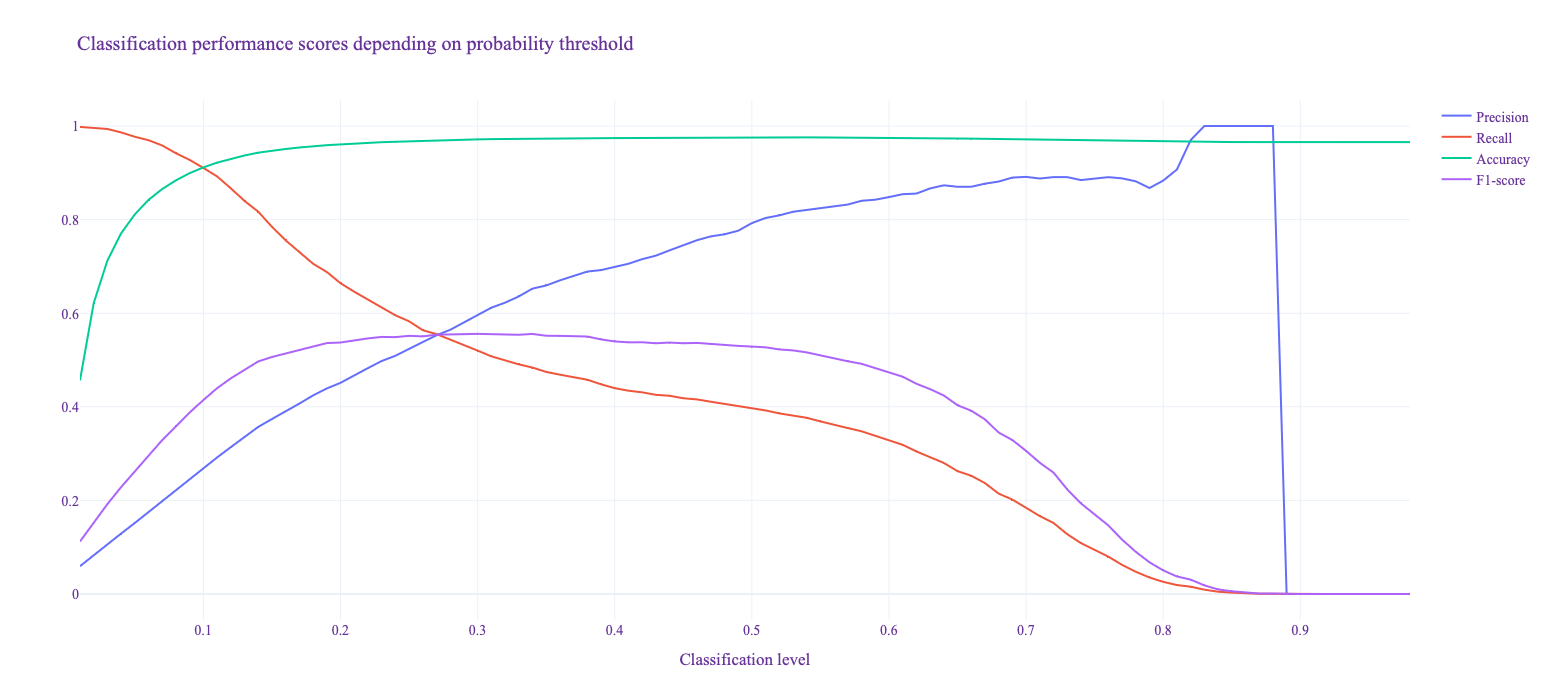

In [10]:
# Plot graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=threshold, y=precision, name="Precision"))
fig.add_trace(go.Scatter(x=threshold, y=recall, name="Recall"))
fig.add_trace(go.Scatter(x=threshold, y=accuracy, name="Accuracy"))
fig.add_trace(go.Scatter(x=threshold, y=f1, name="F1-score"))
fig.update_layout(title="Classification performance scores depending on probability threshold",
                  xaxis_title="Classification level",
                  font=dict(family="Times New Roman, monospace", size=14, color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

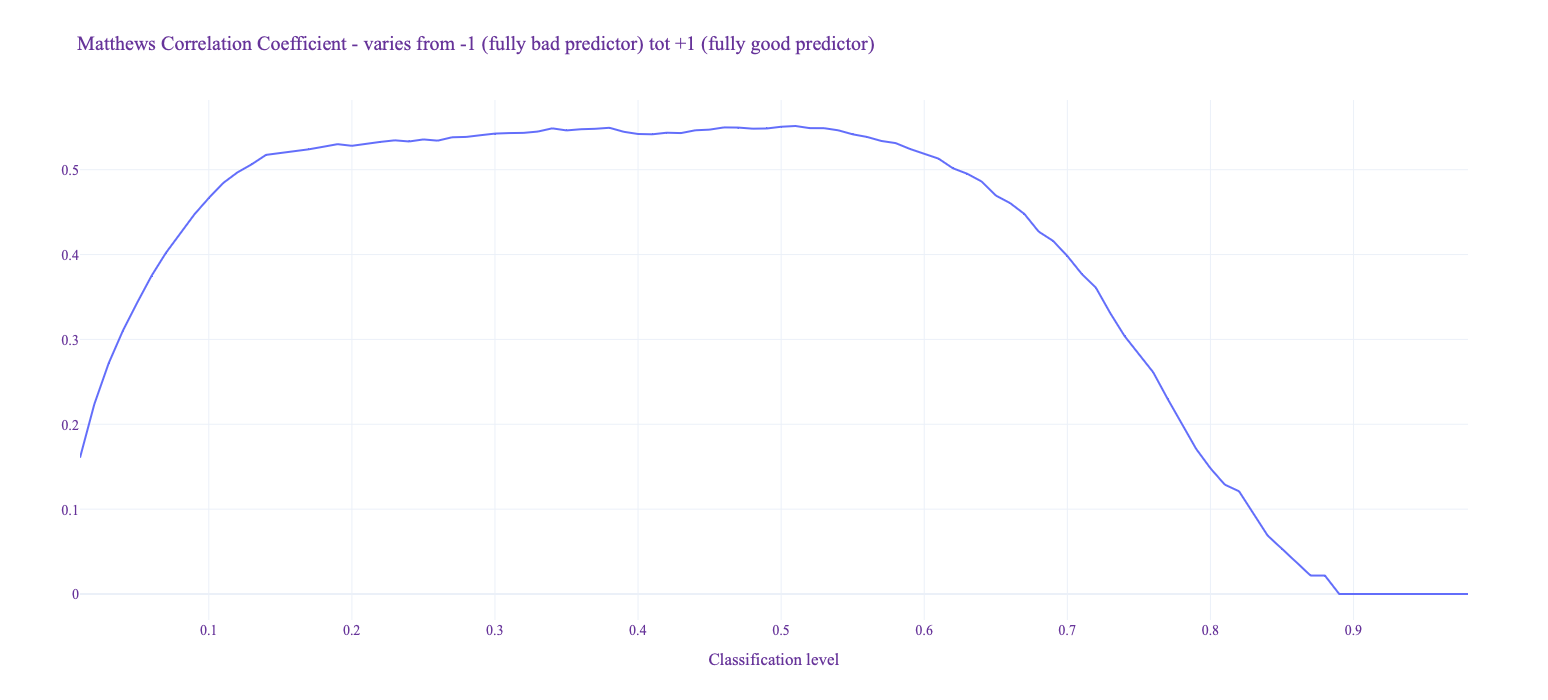

In [11]:
# Matthews Correlation Coefficient varying the threshold
fig = go.Figure()
fig.add_trace(go.Scatter(x=threshold, y=mcc))
fig.update_layout(title="Matthews Correlation Coefficient - varies from -1 (fully bad predictor) tot +1 (fully good predictor)",
                  xaxis_title="Classification level",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

$p=0.3$ seems to be a good threshold

In [18]:
thresh_opt = 0.3
y_probs = modelCla_iter2.predict_proba(X_test)[:,1]
y_pred = y_probs >= thresh_opt

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     57293
           1       0.60      0.52      0.56      2042

    accuracy                           0.97     59335
   macro avg       0.79      0.75      0.77     59335
weighted avg       0.97      0.97      0.97     59335



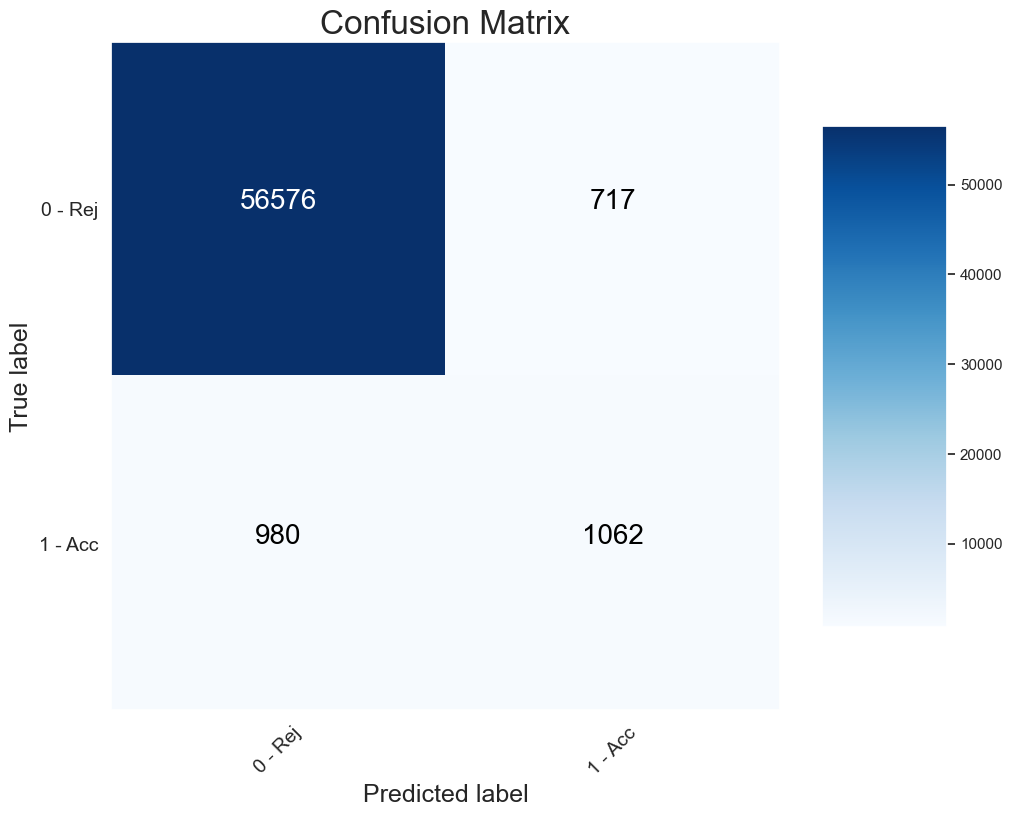

In [20]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Rej', '1 - Acc'], title = 'Confusion Matrix')

 There are 89 features in total


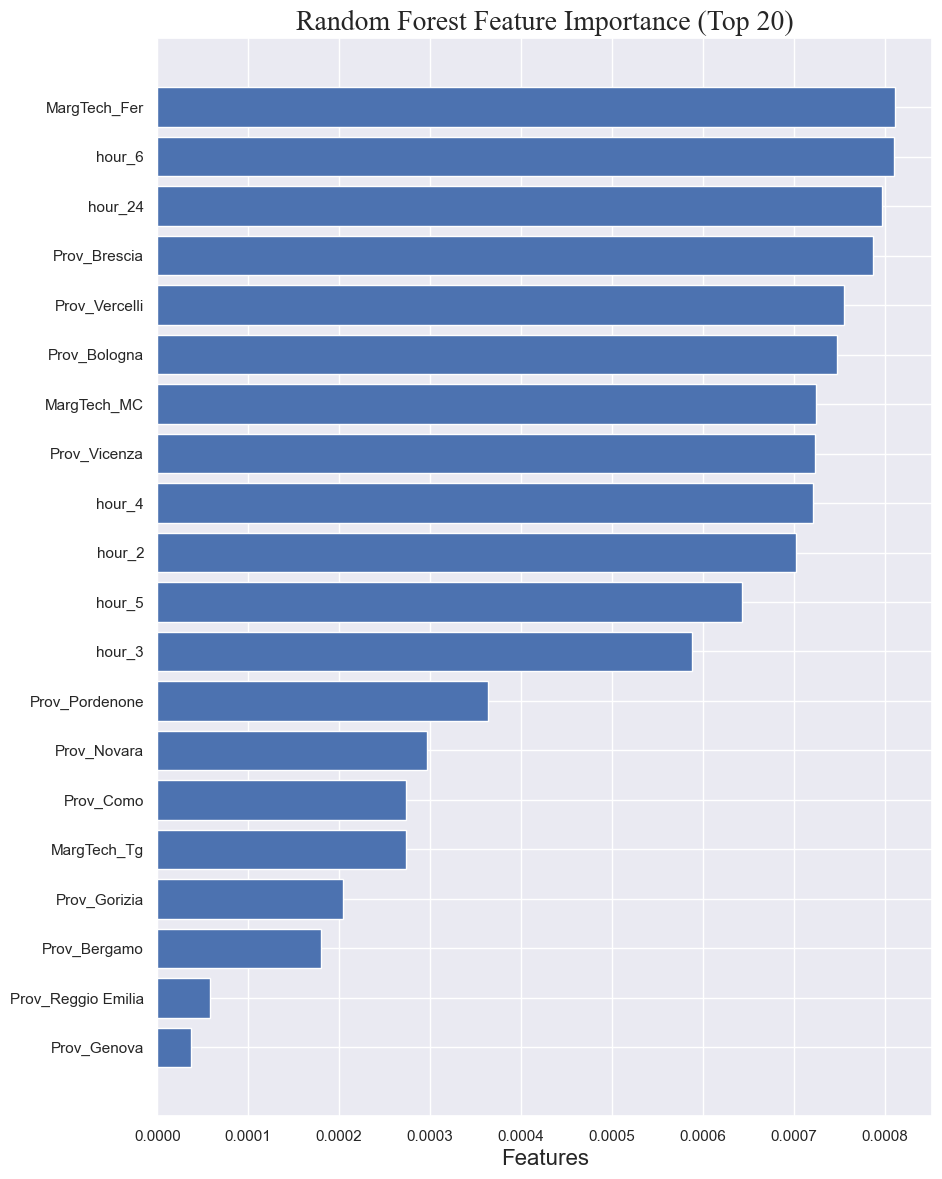

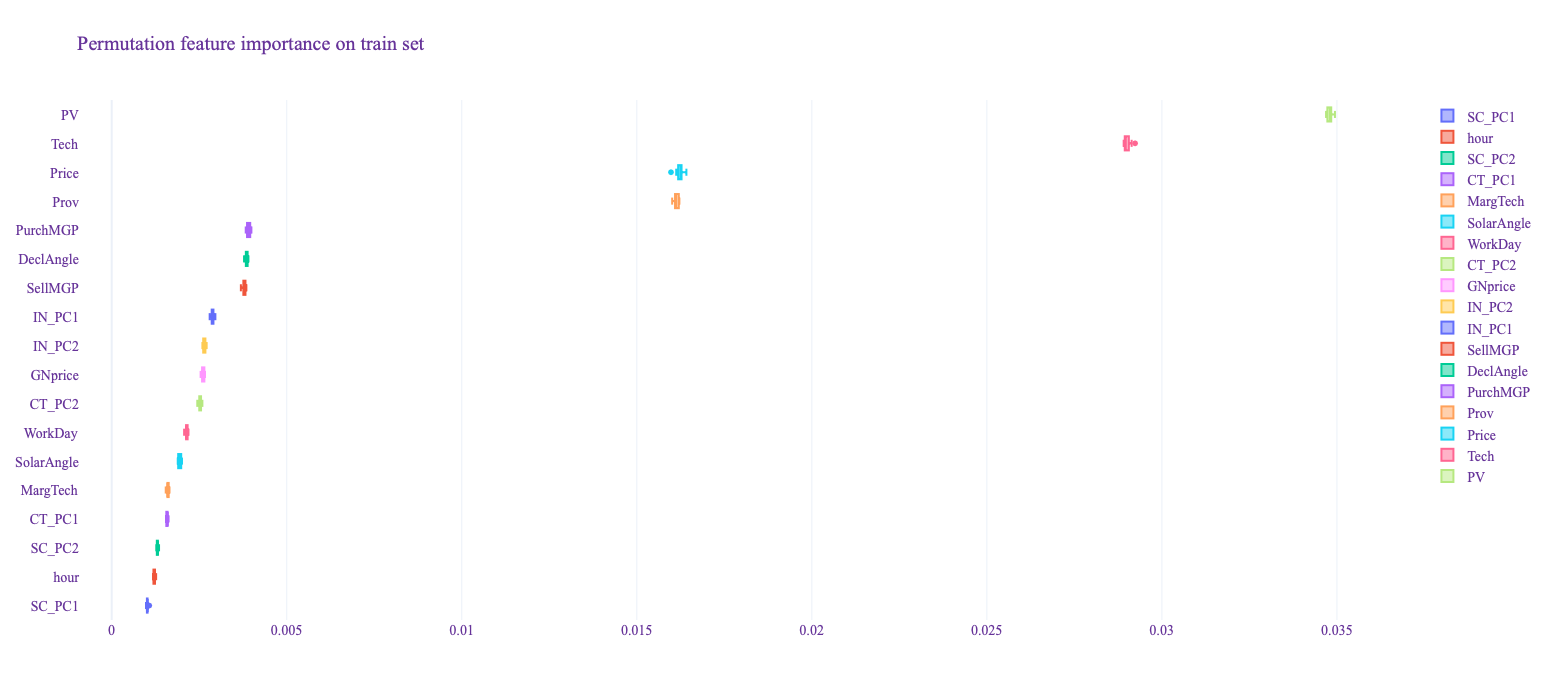

In [23]:
### 3) Feature Importance ###
#------------- Impurity based (depends on impurity used in model training) -------------####
#print(rf_class.feature_importances_)
print(f" There are {len(rf_class.feature_importances_)} features in total") # extra features wrt to train dataset columns are due to encoding
# (need to rebuild the original features to evaluate the importance)

#print(feature_trans.fit_transform(X_train)[0,:])
#print(X_train.iloc[0])
#print("# You see numerical variables are at the end")

def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, categorical_features) # X_train with encoded categorical features

feature_importances = list(zip(X_train_encoded, rf_class.feature_importances_))
# riordino in ordine decrescente di importanza
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = False)
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked]
# plotting the freature importance (top 20)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 20)', fontdict= {'fontname':'Times New Roman','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

###------------ Permutation Feature Importance ------------####
# Hold-out test set
perm_feat_test = permutation_importance(modelCla_iter2, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = perm_feat_test.importances_mean.argsort()
fig = go.Figure()
for i in range(len(sorted_idx)):
    fig.add_trace(go.Box(x=perm_feat_test.importances[sorted_idx[i]].T,name=X_test.columns[sorted_idx[i]]))
#fig.add_trace(go.Box(x=X_test.columns[sorted_idx[1]]))
fig.update_layout(title="Permutation feature importance on hold-out test set",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

# Training set
perm_feat_train = permutation_importance(modelCla_iter2, X_train, y_train, n_repeats=10,random_state=42, n_jobs=2)
sorted_idx = perm_feat_train.importances_mean.argsort()
fig = go.Figure()
for i in range(len(sorted_idx)):
    fig.add_trace(go.Box(x=perm_feat_train.importances[sorted_idx[i]].T,name=X_test.columns[sorted_idx[i]]))
#fig.add_trace(go.Box(x=X_test.columns[sorted_idx[1]]))
fig.update_layout(title="Permutation feature importance on train set",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white", width=1000, height=700)
fig.show()

From the output of the Permutation Feature Importance (PFI), we can clearly identify a group of four variables that reflect the model behaviour:
- `Tech` (technology of the power unit)
- `PV` (value between 0 and 1 indicating the ratio of the actual power on the maximum power)
- `Price` (price proposed per MWh)
- `Prov` (Province in which the power plant is located)

Let's now inspect the more precise behaviour with the Partial Dependence Plots (PDPs)

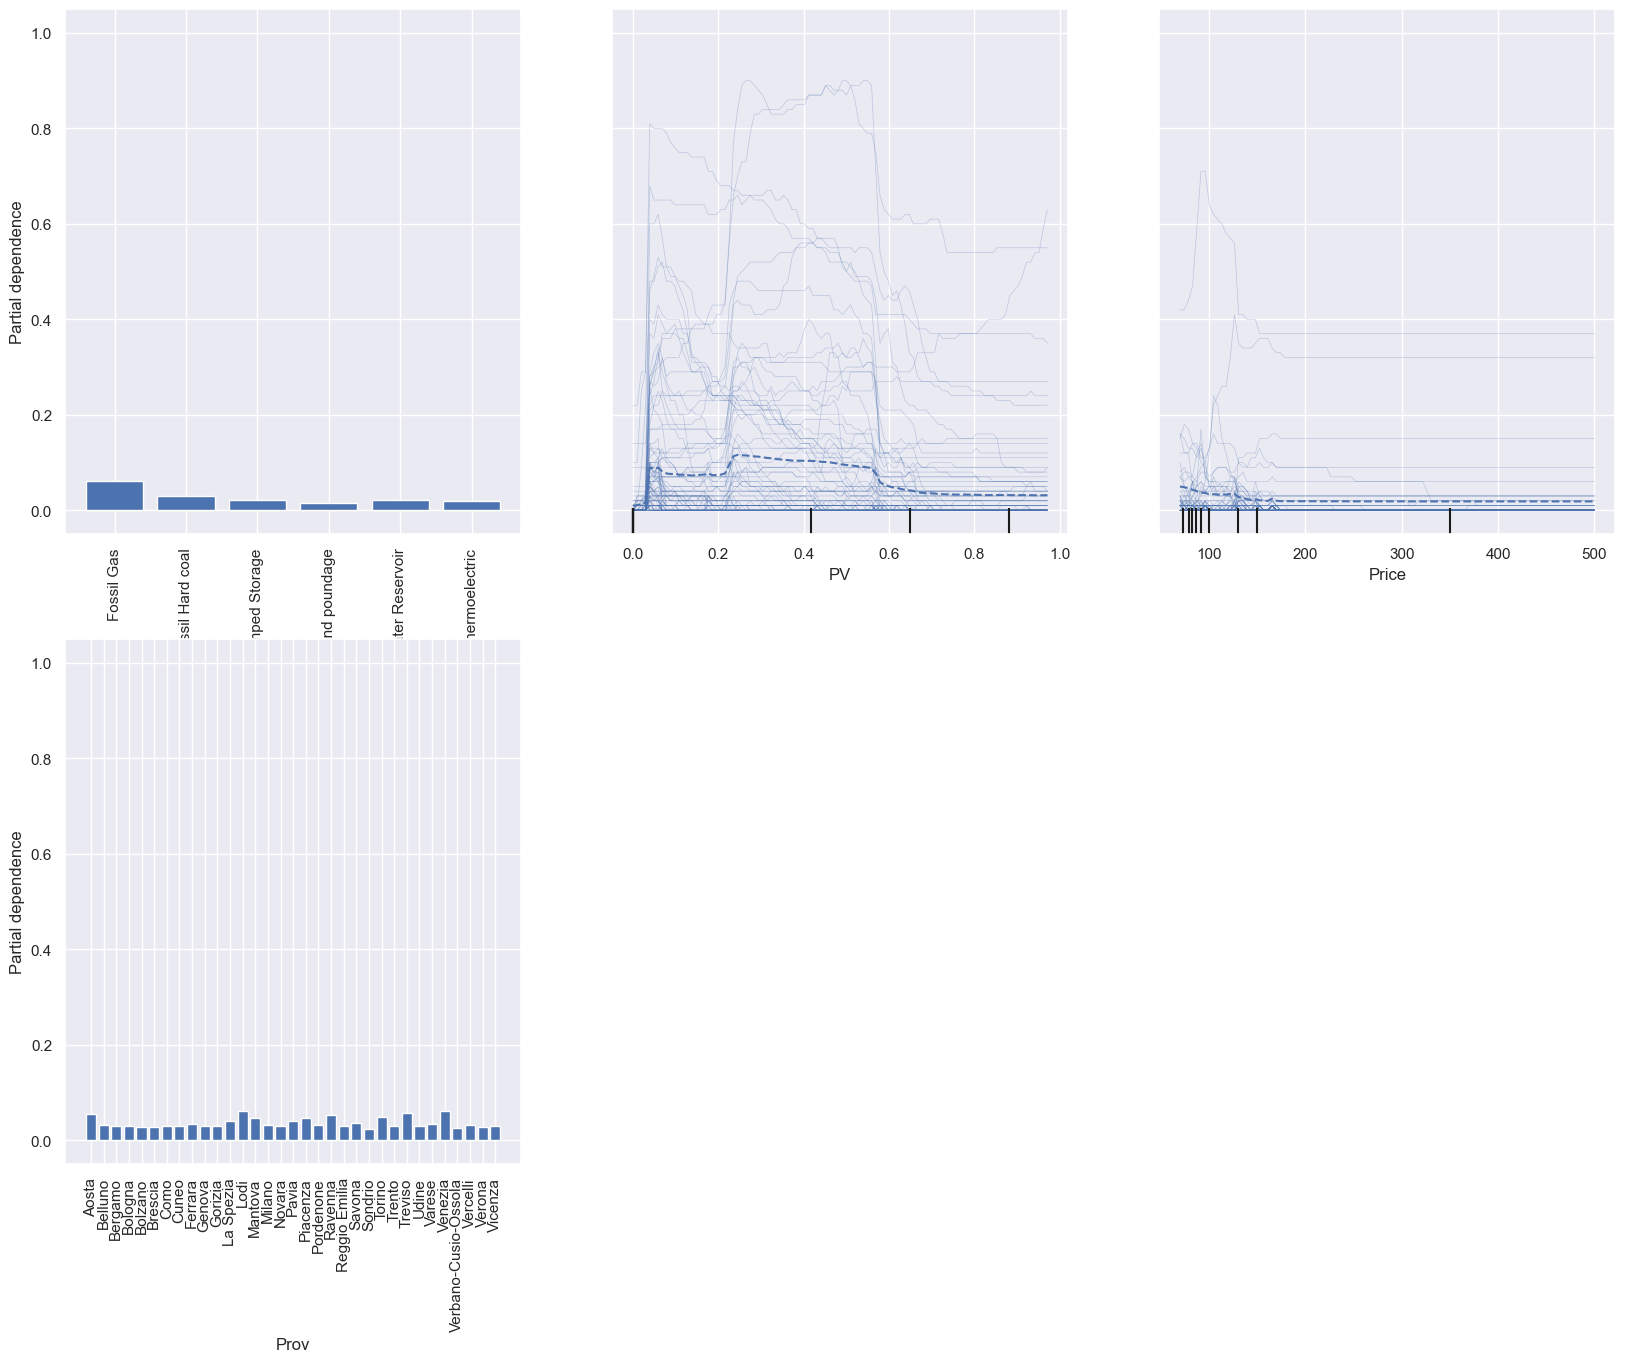

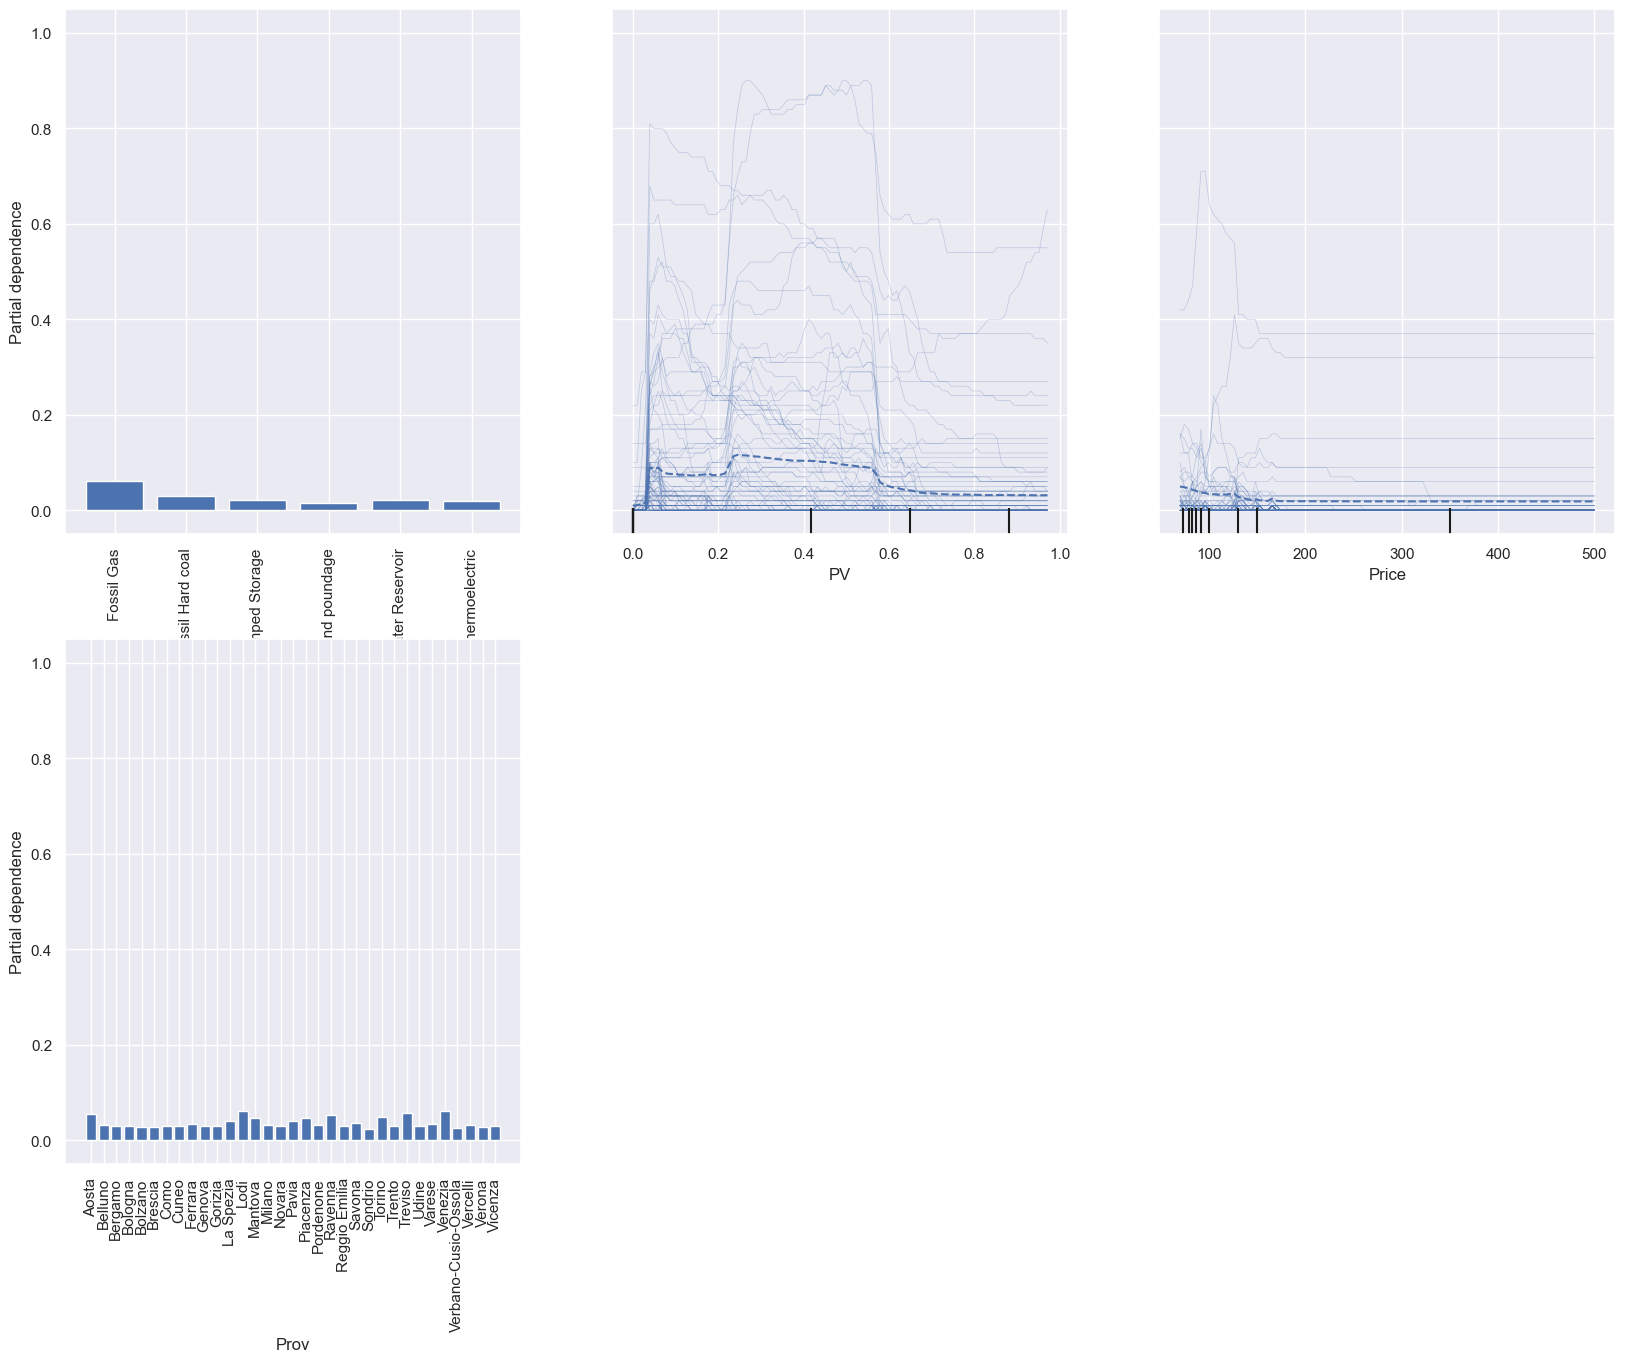

In [25]:
# Partial Dependence Plots (PDPs)
disp = PartialDependenceDisplay.from_estimator(
    modelCla_iter2,
    X = X_train,
    features = ['Tech', 'PV', 'Price', 'Prov'],
    categorical_features = np.array([col in categorical_features for col in X_train.columns.to_list()]),
    n_jobs = -1,
    kind = ['average', 'both', 'both', 'average'],
    subsample = 100
)

disp.figure_.set_size_inches(20, 15)
disp.figure_

## Final estimation on hold-out test set

In [26]:
DB

hour    SC_PC1    SC_PC2    IN_PC1    IN_PC2  \
idx                                                                        
01/01/20191UP_ACTV_1           1  3.353367  0.050663  -3.76401  0.464396   
01/01/201916UP_MORASCO_1      16   -0.9819  3.510884 -2.734184  1.383249   
01/01/201916UP_NOCE_1         16   -0.9819  3.510884 -2.734184  1.383249   
01/01/201916UP_NOVEL_1        16   -0.9819  3.510884 -2.734184  1.383249   
01/01/201916UP_NPWRFRRRRB_8   16   -0.9819  3.510884 -2.734184  1.383249   
...                          ...       ...       ...       ...       ...   
30/11/20198UP_S.PANCRAZ_1      8  0.901807   0.01381 -1.454776 -0.625678   
30/11/20198UP_SANGIACOMO_1     8  0.901807   0.01381 -1.454776 -0.625678   
30/11/20198UP_SCTNPWPFRR_3     8  0.901807   0.01381 -1.454776 -0.625678   
30/11/20198UP_SERMIDE_3        8  0.901807   0.01381 -1.454776 -0.625678   
30/11/20198UP_S.MASS.CL_1      8  0.901807   0.01381 -1.454776 -0.625678   

                               CT_PC1    CT_PC2   PurchMGP    SellMGP  \
idx                                                                     
01/01/20191UP_ACTV_1        -1.042284  2.704958  11460.324   9179.693   
01/01/201916UP_MORASCO_1    -1.042284  2.704958    12621.0   8529.139   
01/01/201916UP_NOCE_1       -1.042284  2.704958    12621.0   8529.139   
01/01/201916UP_NOVEL_1      -1.042284  2.704958    12621.0   8529.139   
01/01/201916UP_NPWRFRRRRB_8 -1.042284  2.704958    12621.0   8529.139   
...                               ...       ...        ...        ...   
30/11/20198UP_S.PANCRAZ_1    0.002441  -0.52625  17453.997  13888.289   
30/11/20198UP_SANGIACOMO_1   0.002441  -0.52625  17453.997  13888.289   
30/11/20198UP_SCTNPWPFRR_3   0.002441  -0.52625  17453.997  13888.289   
30/11/20198UP_SERMIDE_3      0.002441  -0.52625  17453.997  13888.289   
30/11/20198UP_S.MASS.CL_1    0.002441  -0.52625  17453.997  13888.289   

                            MargTech GNprice  SolarAngle  DeclAngle  WorkDay  \
idx                                                                            
01/01/20191UP_ACTV_1            Ccgt   23.11 -178.226106 -23.011637  holiday   
01/01/201916UP_MORASCO_1        Ccgt   23.11   46.773894 -23.011637  holiday   
01/01/201916UP_NOCE_1           Ccgt   23.11   46.773894 -23.011637  holiday   
01/01/201916UP_NOVEL_1          Ccgt   23.11   46.773894 -23.011637  holiday   
01/01/201916UP_NPWRFRRRRB_8     Ccgt   23.11   46.773894 -23.011637  holiday   
...                              ...     ...         ...        ...      ...   
30/11/20198UP_S.PANCRAZ_1       Ccgt  16.303  -69.714944 -21.969868  holiday   
30/11/20198UP_SANGIACOMO_1      Ccgt  16.303  -69.714944 -21.969868  holiday   
30/11/20198UP_SCTNPWPFRR_3      Ccgt  16.303  -69.714944 -21.969868  holiday   
30/11/20198UP_SERMIDE_3         Ccgt  16.303  -69.714944 -21.969868  holiday   
30/11/20198UP_S.MASS.CL_1       Ccgt  16.303  -69.714944 -21.969868  holiday   

                                 Prov                   Tech        PV  \
idx                                                                      
01/01/20191UP_ACTV_1         Vercelli         Thermoelectric       0.0   
01/01/201916UP_MORASCO_1     Piacenza  Hydro Water Reservoir       0.0   
01/01/201916UP_NOCE_1          Trento  Hydro Water Reservoir       0.0   
01/01/201916UP_NOVEL_1         Novara   Hydro Pumped Storage  0.654088   
01/01/201916UP_NPWRFRRRRB_8     Pavia             Fossil Gas       0.0   
...                               ...                    ...       ...   
30/11/20198UP_S.PANCRAZ_1     Bolzano   Hydro Pumped Storage       0.0   
30/11/20198UP_SANGIACOMO_1      Udine  Hydro Water Reservoir       0.0   
30/11/20198UP_SCTNPWPFRR_3    Ferrara             Fossil Gas       0.0   
30/11/20198UP_SERMIDE_3       Mantova             Fossil Gas       0.0   
30/11/20198UP_S.MASS.CL_1      Trento   Hydro Pumped Storage  0.577951   

                              Price Target Result  
idx                              

In [27]:
X_train = DB.drop('Result', axis=1)
y_train = DB['Result'].astype('int')

X_test = test_DB.drop('Result', axis=1)
y_test = test_DB['Result'].astype('int')

X_test = X_test.drop('Target', axis=1)
X_train = X_train.drop('Target', axis=1)

In [28]:
y_probs = predict_proba_daily_recal(modelCla_iter2, X_train, y_train, X_test, y_test)

  0%|          | 0/31 [00:00<?, ?it/s]

F1-score for day 2019-12-01 00:00:00 is 0.15384615384615385
[[2225   38]
 [   6    4]]


F1-score for day 2019-12-02 00:00:00 is 0.5571428571428572
[[1885   42]
 [  20   39]]


F1-score for day 2019-12-03 00:00:00 is 0.7085714285714284
[[1705   40]
 [  11   62]]


F1-score for day 2019-12-04 00:00:00 is 0.5192307692307693
[[1786   45]
 [   5   27]]


F1-score for day 2019-12-05 00:00:00 is 0.776978417266187
[[1678   18]
 [  13   54]]


F1-score for day 2019-12-06 00:00:00 is 0.6725663716814159
[[1902   17]
 [  20   38]]


F1-score for day 2019-12-07 00:00:00 is 0.4
[[1994   17]
 [   7    8]]


F1-score for day 2019-12-08 00:00:00 is 0.3703703703703703
[[2141   11]
 [   6    5]]


F1-score for day 2019-12-09 00:00:00 is 0.47761194029850745
[[1873   42]
 [  28   32]]


F1-score for day 2019-12-10 00:00:00 is 0.5306122448979591
[[2008   40]
 [   6   26]]


F1-score for day 2019-12-11 00:00:00 is 0.6212121212121212
[[1945   36]
 [  14   41]]


F1-score for day 2019-12-12 00:00:00 is 0.7021

In [29]:
y_probs = pd.Series(y_probs[:,1], index=y_test.index)
with open("predict_probs_series_december_up.pkl", 'wb') as file:
    pickle.dump(y_probs, file)

In [30]:
y_pred = y_probs >= .3
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     64985
           1       0.61      0.68      0.64      2213

    accuracy                           0.97     67198
   macro avg       0.80      0.83      0.81     67198
weighted avg       0.98      0.97      0.98     67198



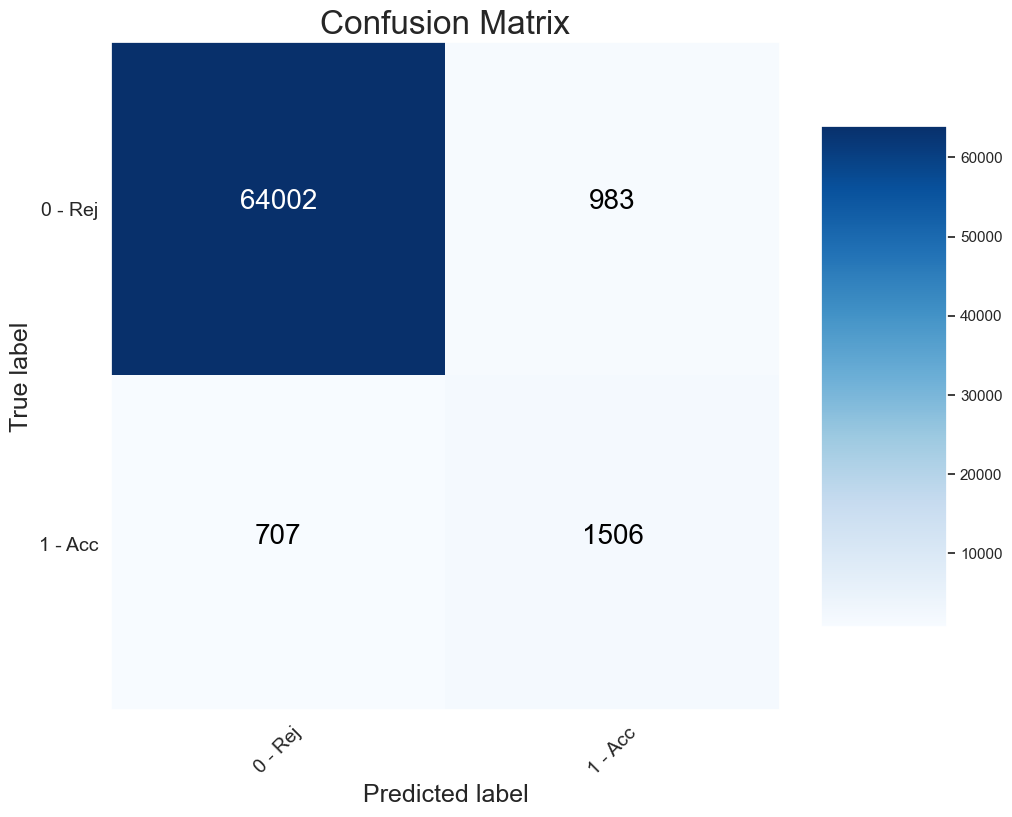

In [31]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - Rej', '1 - Acc'], title = 'Confusion Matrix')

In [32]:
# Time Series Cross Validation metrics
test_dates = pd.to_datetime(y_test.index.str[:10], format="%d/%m/%Y")
distinct_dates = test_dates.unique()

precision = []
recall = []
mcc = []
accuracy = []
f1 = []


for date in tqdm(distinct_dates):
    y_test_day = y_test[test_dates == date]
    y_pred_day = y_pred[test_dates == date]
    
    precision.append(precision_score(y_test_day, y_pred_day))
    recall.append(recall_score(y_test_day, y_pred_day))
    mcc.append(matthews_corrcoef(y_test_day, y_pred_day))
    accuracy.append(accuracy_score(y_test_day, y_pred_day))
    f1.append(f1_score(y_test_day, y_pred_day))

  0%|          | 0/31 [00:00<?, ?it/s]

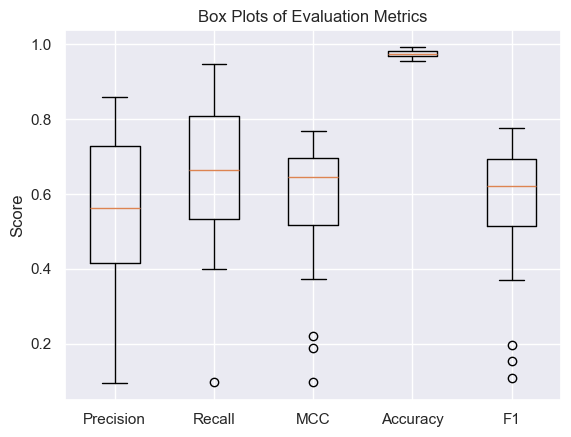

In [33]:
fig, ax = plt.subplots()

# Create box plots for each list aligned horizontally
boxplots = ax.boxplot([precision, recall, mcc, accuracy, f1], labels=['Precision', 'Recall', 'MCC', 'Accuracy', 'F1'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Box Plots of Evaluation Metrics')

# Show the plot
plt.show()

1
2
3
4
5
6
7
8
9
Mean of predicted variable (Target): 0.2548087755107253


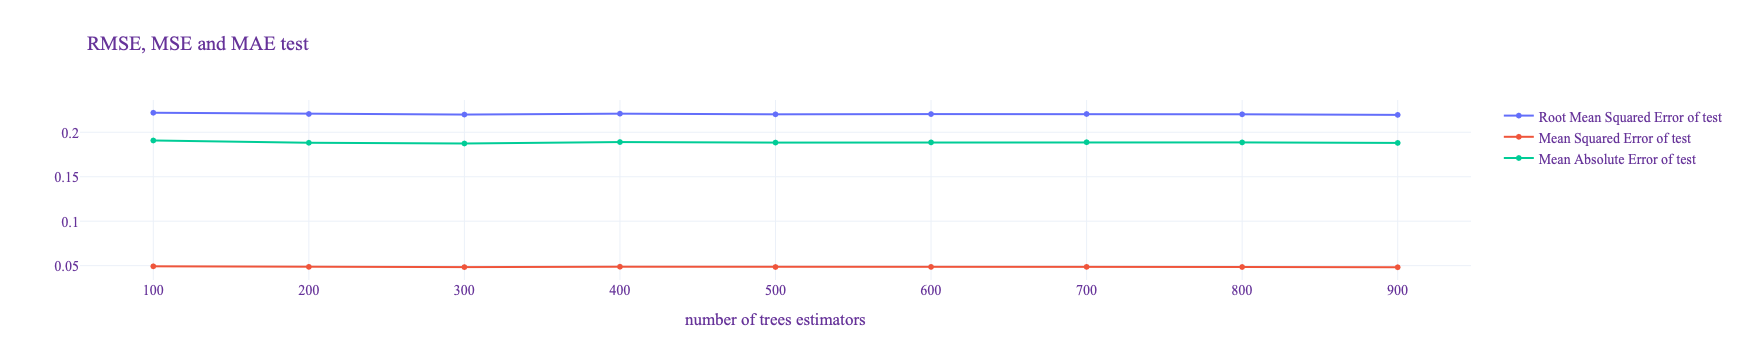

In [10]:
### 1) Build the regression model on accepted samples ('Result'=1)
### 2) Evaluate the model: R2, MSE, MAE, ROOT MSE, oob
### 3) Extract the oob error for unsampled indexes for each baootstrapped tree
### 4) Extract as an array oob errorrs of a specific daytime range
### 5) Use it in a roulette wheel to associate uncertainty to the model prediction

### 1) Builging the regression model
#--> Per definire il dataset di partenza ho 3 soluzioni
choose_method=2

if choose_method==1:
    ## 1: Extract from the original DB only accepted offer (Result==1), discarding Result and Target in X_train, using Target as y_train
    X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(
                    DB[DB['Result']>0].drop('Result', axis=1).drop('Target', axis=1), 
                    DB[DB['Result']>0]['Target'], 
                    test_size = 0.333, shuffle=False, random_state=42) # random state used to control the model seed
elif choose_method==2:
    ## 2: Predict with the classification model on the original dataset and take only samples predicted as accepted (some actual accepted samples will remain outside bcs they are predicted as rejected)
    X1=X.copy()
    X0=X.drop('Target',axis=1)
    pred_result = (modelCla.predict_proba(X0)[:,1] >= thresh_opt).astype(bool)
    X1['pred_result'] = pred_result
    X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(
                    X1[X1['pred_result']==1].drop('Target', axis=1).drop('pred_result', axis=1), 
                    X1[X1['pred_result']>0]['Target'], 
                    test_size = 0.333, shuffle=False, random_state=42) # random state used to control the model seed
elif choose_method==3:
    ## 3: Take all the accepted and some rejected in percentage of the false positive of the classification model
    X1=X[X['Target']>0] # only accepted
    X2=X[X['Target']==0] # only rejected
    fp = cm[0,1] # false positives
    attach=X2.sample(n=fp)
    X1=X1.append(attach) # final starting DB
    X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(
                    X1.drop('Target', axis=1), 
                    X1['Target'], 
                    test_size = 0.333, shuffle=False, random_state=42) # random state used to control the model seed


#------- HYPERPARAMETERS OPTIMIZATION -----#
# Optimal number of estimators (trees) based on accuracy and OOB error
idx=0

start=100
end=1000
step=100

trees = [None] * round(end/step)
oob_result = [None] * round(end/step)
mse_result = [None] * round(end/step)
rmse_result = [None] * round(end/step)
mae_result = [None] * round(end/step)

for n_est in range(start,end,step):
    trees[idx] = n_est
    
    feature_trans_regr = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'),categorical_features), # se tolgo handle unknown errore perchè alcune categorical non le ha nel training ma le ha nel test --> forse si risolve se DB grande
        (StandardScaler(), numeric_features), 
         remainder="passthrough") # passing not-cited columns as untouched
    
    rf_regr = RandomForestRegressor(
                    n_estimators=n_est, criterion="mse", oob_score=True,
                    min_samples_leaf=1, max_features= "sqrt", bootstrap=True, 
                    random_state=42)
    
    modelRegr_iter1 = make_pipeline(feature_trans_regr, rf_regr)
    
    modelRegr_iter1.fit(X_train_regr, y_train_regr)   
    y_pred_regr_iter1 = modelRegr_iter1.predict(X_test_regr)
    
    mse_result[idx] = metrics.mean_squared_error(y_test_regr, y_pred_regr_iter1)
    rmse_result[idx] = np.sqrt(metrics.mean_squared_error(y_test_regr, y_pred_regr_iter1))
    mae_result[idx] = metrics.mean_absolute_error(y_test_regr, y_pred_regr_iter1)
    
    idx+=1
    print(idx)

mean_pred=np.mean(DB[DB['Result']>0]['Target'])
print(f'Mean of predicted variable (Target): {mean_pred}')
# Plot graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=trees,y=rmse_result, name="Root Mean Squared Error of test"))
fig.add_trace(go.Scatter(x=trees,y=mse_result, name="Mean Squared Error of test"))
fig.add_trace(go.Scatter(x=trees,y=mae_result, name="Mean Absolute Error of test"))
fig.update_layout(title="RMSE, MSE and MAE test",xaxis_title="number of trees estimators",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white")

fig.show()

In [11]:
# ---------- REGRESSION ------------ #
## Building the regression model: random forest fitting on data
n_est_opt_regr = 200

if not(os.path.isfile('modelRegressor.joblib')):
    rf_regr = RandomForestRegressor(
                    n_estimators=n_est_opt_regr, criterion="mse", oob_score=True,
                    min_samples_leaf=1, max_features= "sqrt", bootstrap=True, 
                    random_state=42)
    
    modelRegr = make_pipeline(feature_trans_regr, rf_regr)
    
    print("Training regressor...")
    modelRegr.fit(X_train_regr, y_train_regr)
    #joblib.dump(modelRegr, 'modelRegressor.joblib');
else:
    modelRegr = joblib.load('modelRegressor.joblib');

#Regressor
print("Predicting with Regressor...")
y_pred_regr = modelRegr.predict(X_test_regr)

### 2) Evaluation of model performances
print(f'MSE: {metrics.mean_squared_error(list(y_test_regr), list(y_pred_regr))}')
print(f'R2: {metrics.r2_score(list(y_test_regr), list(y_pred_regr))}')
print(f'MAE: {metrics.mean_absolute_error(list(y_test_regr), list(y_pred_regr))}')
print(f'ROOT MSE: {np.sqrt(metrics.mean_squared_error(list(y_test_regr), list(y_pred_regr)))}')
mean_pred=np.mean(DB[DB['Result']>0]['Target'])
print(f'Mean of predicted variable (Target): {mean_pred}')


    

Training regressor...
Predicting with Regressor...
MSE: 0.04865472139171809
R2: -2.065852568302591
MAE: 0.1881948926255885
ROOT MSE: 0.22057815257118754
Mean of predicted variable (Target): 0.2548087755107253


In [2]:
### 3) Extract OOB error
# qui è solo per ispezionare le funzioni che ci interessano per estrarre oob da ogni albero ###
source_1 = inspect.getsource(rf_regr._set_oob_score)
#print(source_1)
source_2 = inspect.getsource(_get_n_samples_bootstrap)
#print(source_2)
source_2 = inspect.getsource(_get_n_samples_bootstrap)
#print(source_2)
source_3 = inspect.getsource(_generate_unsampled_indices)
#print(source_3)
source_4 = inspect.getsource(_generate_sample_indices)
#print(source_4)
###############################################################################################

# ------------ EXTRACT OOB ERROR OF EACH DECISION TREE ESTIMATOR --> CLASSIFICATION ----------- #
oob_col = range(0,len(rf_class.estimators_)) # numero di estimatori usati
X_oob_cla=pd.DataFrame(index=X_train_encoded.index,columns=oob_col) # righe: samples ; colonne: estimatori :--> dataframe degli oob di ogni estimatore
i=0
# Computing the oob error
n_samples = X_train_encoded.shape[0] # numero di samples nel train set
#n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, rf_class.max_samples)
for dtree in rf_class.estimators_:
    ##Graphical representation of each tree
    #dot=tree.export_graphviz(dtree, out_file=None) 
    #graph = graphviz.Source(dot) 
    #graph
    
    # Extracting unsampled samples for each DT estimator
    unsampled_indices = _generate_unsampled_indices(dtree.random_state, n_samples, n_samples) # obtain out of bag samples for every tree.
    # Extracting the features used in each tree
    feat = dtree.tree_.feature[dtree.tree_.feature>0]
    # Computing the prediction for the out of bag samples
    X_trenc_arr=np.array(X_train_encoded.iloc[unsampled_indices, :],dtype='float32')
    #p_estimator = dtree.predict(X_trenc_arr, check_input=False)
    p_estimator = (dtree.predict_proba(X_trenc_arr, check_input=False)[:,1] >= thresh_opt).astype(bool)
    
    # Computing the out of bag error for each put of bag sample for the given tree
    X_oob_cla.iloc[unsampled_indices,i] = tuple(p_estimator) - y_train[unsampled_indices]
    i+=1

# ------------ EXTRACT OOB ERROR OF EACH DECISION TREE ESTIMATOR --> REGRESSION ----------- #
X_train_encoded_regr = encode_and_bind(X_train_regr, categorical_features) # X_train with encoded categorical features
oob_col_regr = range(0,len(rf_regr.estimators_)) # numero di estimatori usati
X_oob_regr=pd.DataFrame(index=X_train_encoded_regr.index,columns=oob_col_regr) # righe: samples ; colonne: estimatori :--> dataframe degli oob di ogni estimatore
i=0
# Computing the oob error
n_samples_regr = X_train_encoded_regr.shape[0] # numero di samples nel train set
#n_samples_bootstrap_regr = _get_n_samples_bootstrap(n_samples_regr, rf_regr.max_samples)
for dtree_regr in rf_regr.estimators_:
    ##Graphical representation of each tree
    #dot=tree.export_graphviz(dtree, out_file=None) 
    #graph = graphviz.Source(dot) 
    #graph
    
    # Extracting unsampled samples for each DT estimator
    unsampled_indices_regr = _generate_unsampled_indices(dtree_regr.random_state, n_samples_regr, n_samples_regr) # obtain out of bag samples for every tree.
    # Extracting the features used in each tree
    feat_regr = dtree_regr.tree_.feature[dtree_regr.tree_.feature>0]
    # Computing the prediction for the out of bag samples
    X_trenc_arr_regr=np.array(X_train_encoded_regr.iloc[unsampled_indices_regr, :],dtype='float32')
    #p_estimator = dtree.predict(X_trenc_arr, check_input=False)
    p_estimator_regr = (dtree_regr.predict(X_trenc_arr_regr, check_input=False))
    
    # Computing the out of bag error for each put of bag sample for the given tree
    X_oob_regr.iloc[unsampled_indices_regr,i] = tuple(p_estimator_regr) - y_train_regr[unsampled_indices_regr]
    i+=1

NameError: name 'rf_regr' is not defined

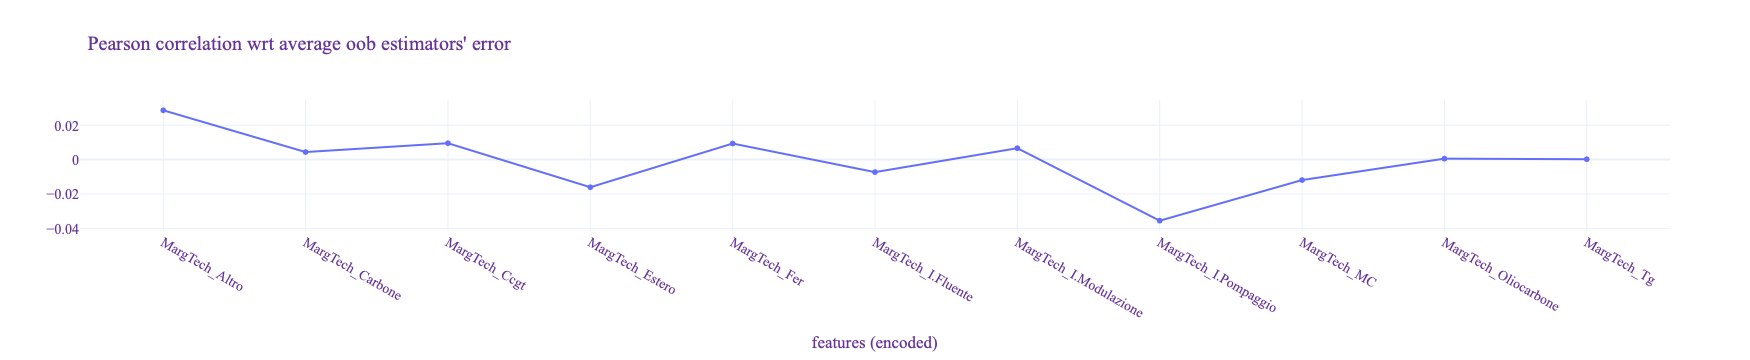

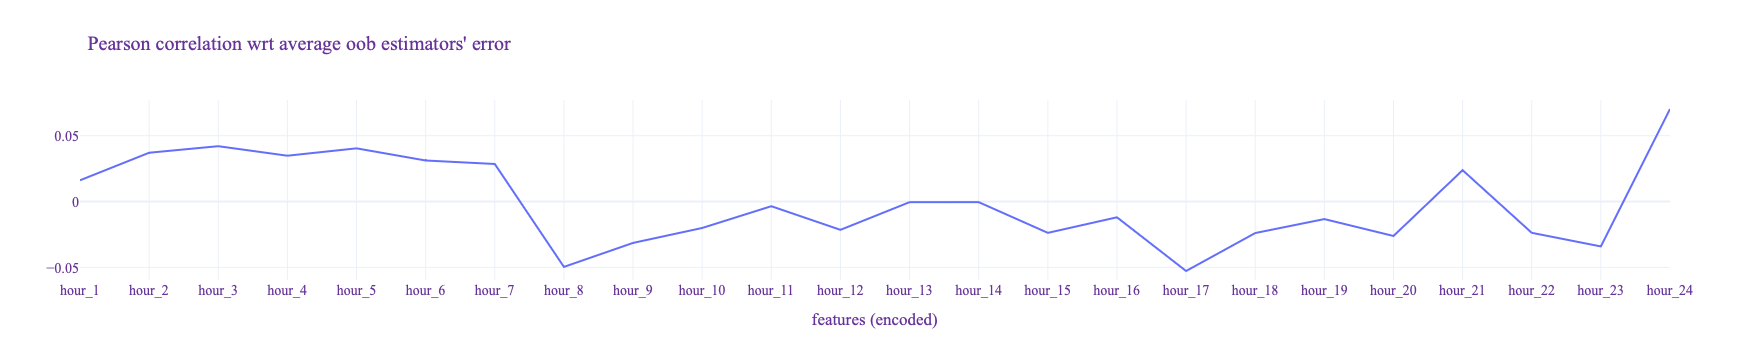

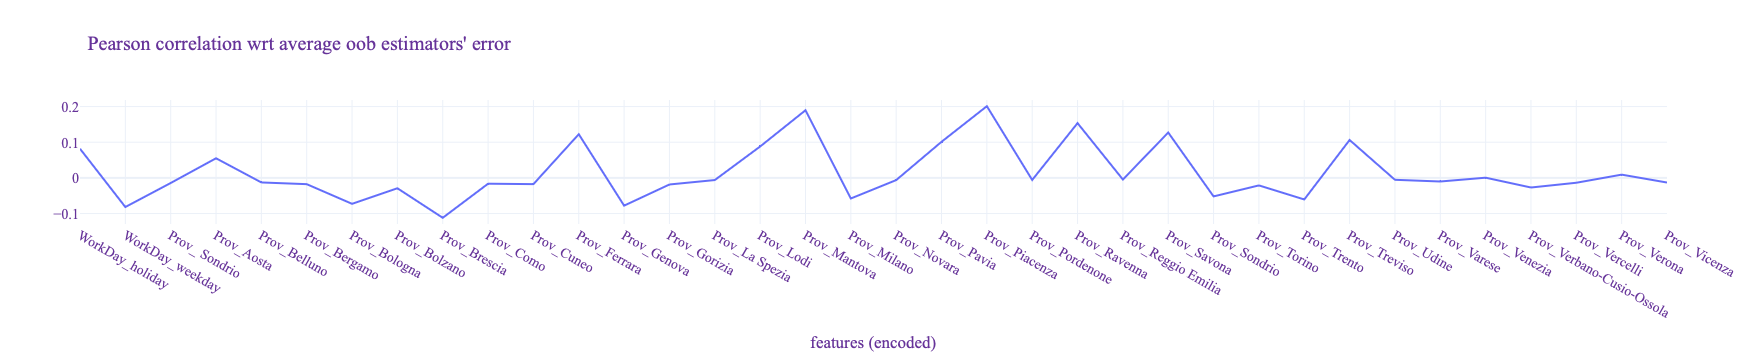

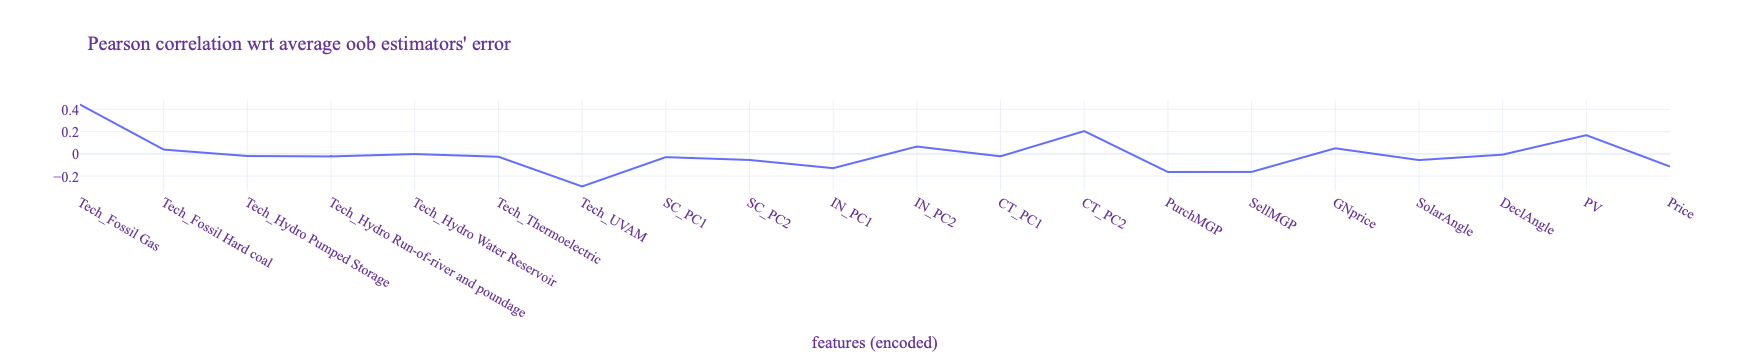

In [13]:
### 4) Extract daytime specific related oob errors
# Correlation btw average error and model features - classification
X_train_encoded['av_err']=X_oob_cla.abs().sum(axis=1)/X_oob_cla.count(axis=1) # axis=1 --> in orizzonatale
corr=X_train_encoded.astype(float).corr(method='pearson')
#fig = go.Figure(data=go.Heatmap(z=corr.values,x=corr.index,y=corr.columns,hoverongaps = False))
#fig.show()

fig=go.Figure(data=go.Scatter(x=corr.columns[:11], y=corr.values[:11,91]))
fig.update_layout(title="Pearson correlation wrt average oob estimators' error",
                  xaxis_title="features (encoded)",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white")
fig.show()

fig=go.Figure(data=go.Scatter(x=corr.columns[11:35], y=corr.values[11:35,91]))
fig.update_layout(title="Pearson correlation wrt average oob estimators' error",
                  xaxis_title="features (encoded)",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white")
fig.show()

fig=go.Figure(data=go.Scatter(x=corr.columns[35:71], y=corr.values[35:71,91]))
fig.update_layout(title="Pearson correlation wrt average oob estimators' error",
                  xaxis_title="features (encoded)",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white")
fig.show()

fig=go.Figure(data=go.Scatter(x=corr.columns[71:], y=corr.values[71:-1,91]))
fig.update_layout(title="Pearson correlation wrt average oob estimators' error",
                  xaxis_title="features (encoded)",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white")
fig.show()

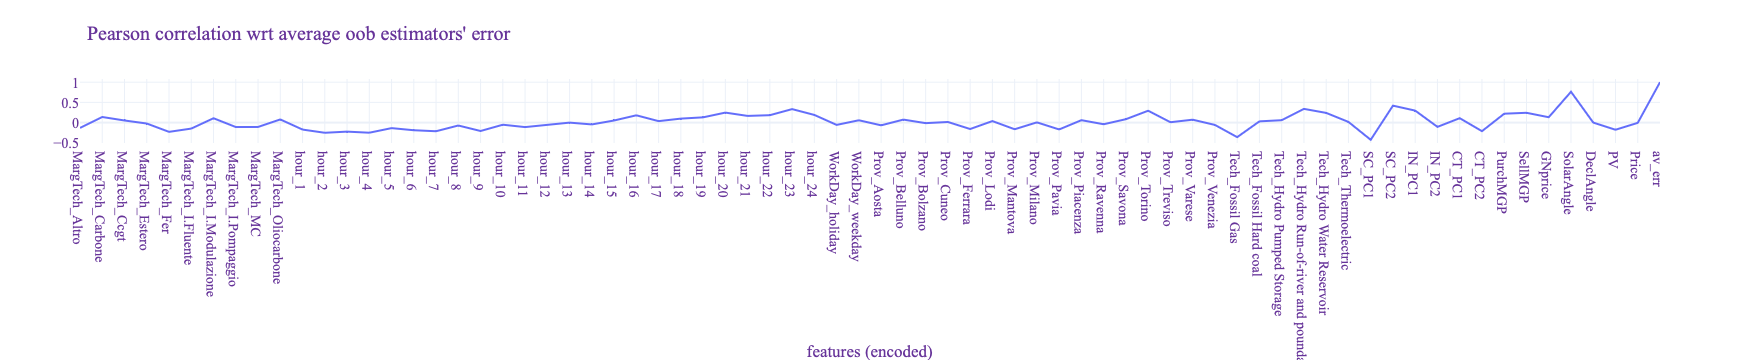

In [42]:
# Correlation btw average error and model features - regression ---> da sistemare in base alla feature che ti escono
X_train_encoded_regr['av_err']=X_oob_regr.abs().sum(axis=1)/X_oob_regr.count(axis=1)
corr=X_train_encoded_regr.astype(float).corr(method='pearson')
#fig = go.Figure(data=go.Heatmap(z=corr.values,x=corr.index,y=corr.columns,hoverongaps = False))
#fig.show()

fig=go.Figure(data=go.Scatter(x=corr.columns, y=corr.values[-1]))
fig.update_layout(title="Pearson correlation wrt average oob estimators' error",
                  xaxis_title="features (encoded)",
                  font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                  template="plotly_white")
fig.show()


In [15]:
# Add an information about the hour and extract from dataframe only samples associated to a specific set of hours
shoulder = [6,7,8,9,17,18,19,20]
peak = [10,11,12,13,14,15,16]
offpeak = [21,22,23,24,1,2,3,4,5]

X_oob_cla['hour']=X_train['hour']
X_oob_regr['hour']=X_train_regr['hour']

groupCla_offpeak=X_oob_cla.loc[X_oob_cla['hour'].isin(offpeak)]
groupCla_peak=X_oob_cla.loc[X_oob_cla['hour'].isin(peak)]
groupCla_shoulder=X_oob_cla.loc[X_oob_cla['hour'].isin(shoulder)]

groupRegr_offpeak=X_oob_regr.loc[X_oob_regr['hour'].isin(offpeak)]
groupRegr_peak=X_oob_regr.loc[X_oob_regr['hour'].isin(peak)]
groupRegr_shoulder=X_oob_regr.loc[X_oob_regr['hour'].isin(shoulder)]

# Definisco array con l'errore per ogni intervallo di ore - classificazione
a=groupCla_offpeak.drop('hour',axis=1)
a=a.apply(lambda x: pd.Series(x.dropna().values))
a=a.dropna()
offpeak_err_cla=a.values.astype(float)

a=groupCla_peak.drop('hour',axis=1)
a=a.apply(lambda x: pd.Series(x.dropna().values))
a=a.dropna()
peak_err_cla=a.values.astype(float)

a=groupCla_shoulder.drop('hour',axis=1)
a=a.apply(lambda x: pd.Series(x.dropna().values))
a=a.dropna()
shoulder_err_cla=a.values.astype(float)

# Definisco array con l'errore per ogni intervallo di ore - regressione
a=groupRegr_offpeak.drop('hour',axis=1)
a=a.apply(lambda x: pd.Series(x.dropna().values))
a=a.dropna()
offpeak_err_regr=a.values.astype(float)

a=groupRegr_peak.drop('hour',axis=1)
a=a.apply(lambda x: pd.Series(x.dropna().values))
a=a.dropna()
peak_err_regr=a.values.astype(float)

a=groupRegr_shoulder.drop('hour',axis=1)
a=a.apply(lambda x: pd.Series(x.dropna().values))
a=a.dropna()
shoulder_err_regr=a.values.astype(float)

#### ---> ora non mi resta che portare tutti i valori estratti un un array, trasformarlo in una distribuzione dell'errore (andrà da -1 a 1)
#### e applicare questo errore al profilo base previsto dal modello (output del modello) tramite una roulette wheel

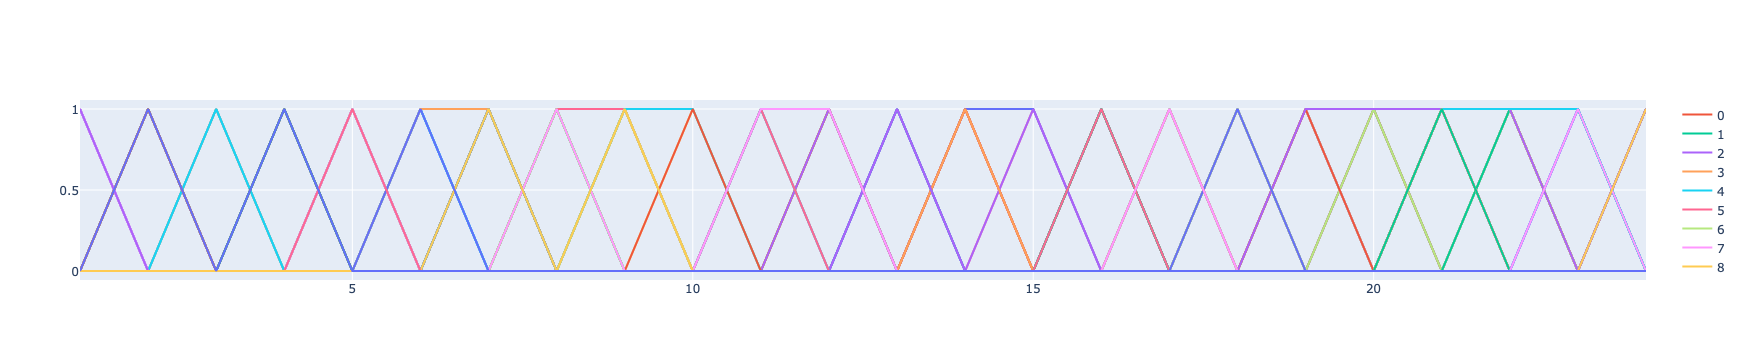

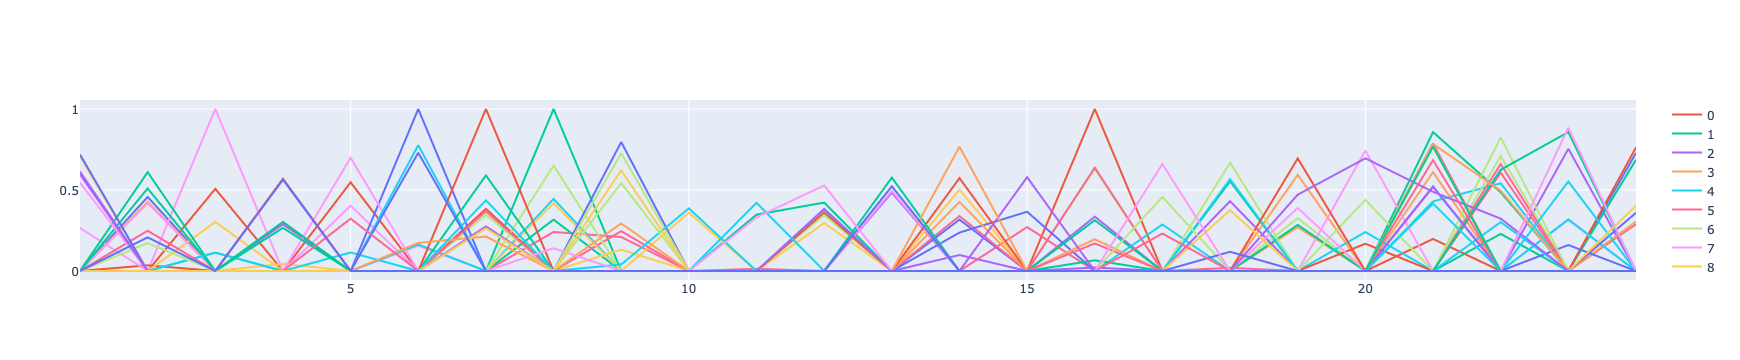

In [88]:
### 5) Create scenaios through a roulette-wheel application of oob errors
# Import the feature profile for the day to be modelled
Gaia=pd.read_excel('feat_ref.xlsx')
# Define the rounds number for the roulette wheel and create the scenarios table
rounds=100
scenarios_cla= pd.DataFrame(index=range(24), columns=range(0,rounds))
scenarios_regr= pd.DataFrame(index=range(24), columns=range(0,rounds))
# Apply the classification model on the feature profile imported
ClaResult = (modelCla.predict_proba(Gaia)[:,1] >= thresh_opt).astype(bool)
fig1=go.Figure(data=go.Scatter())
fig2=go.Figure(data=go.Scatter())

# Calculate the scenarios with a roulette wheel approach
for roul_wheel in range(0,rounds):
    for i in offpeak:
        scenarios_cla.iloc[i-1][roul_wheel]=ClaResult[i-1]+random.choice(random.choice(offpeak_err_cla))
        if scenarios_cla.iloc[i-1][roul_wheel]==0:
            scenarios_regr.iloc[i-1][roul_wheel]=0
        elif scenarios_cla.iloc[i-1][roul_wheel]==1:
            scenarios_regr.iloc[i-1][roul_wheel]=modelRegr.predict(Gaia.iloc[[i-1]])[0]+random.choice(random.choice(offpeak_err_regr))
    for i in shoulder:
        scenarios_cla.iloc[i-1][roul_wheel]=ClaResult[i-1]+random.choice(random.choice(shoulder_err_cla))
        if scenarios_cla.iloc[i-1][roul_wheel]==0:
            scenarios_regr.iloc[i-1][roul_wheel]=0
        elif scenarios_cla.iloc[i-1][roul_wheel]==1:
            scenarios_regr.iloc[i-1][roul_wheel]=modelRegr.predict(Gaia.iloc[[i-1]])[0]+random.choice(random.choice(shoulder_err_regr))
    for i in peak:
        scenarios_cla.iloc[i-1][roul_wheel]=ClaResult[i-1]+random.choice(random.choice(peak_err_cla))
        if scenarios_cla.iloc[i-1][roul_wheel]==0:
            scenarios_regr.iloc[i-1][roul_wheel]=0
        elif scenarios_cla.iloc[i-1][roul_wheel]==1:
            scenarios_regr.iloc[i-1][roul_wheel]=modelRegr.predict(Gaia.iloc[[i-1]])[0]+random.choice(random.choice(peak_err_regr))
    scenarios_cla[roul_wheel][scenarios_cla[roul_wheel]<0]=0
    scenarios_cla[roul_wheel][scenarios_cla[roul_wheel]>1]=1
    scenarios_regr[roul_wheel][scenarios_regr[roul_wheel]<0]=0
    scenarios_regr[roul_wheel][scenarios_regr[roul_wheel]>1]=1
    scenarios_regr[scenarios_regr.isnull()]=0
    
    fig1.add_trace(go.Scatter(x=scenarios_cla.index+1,y=scenarios_cla[roul_wheel], name=str(roul_wheel)))
    fig2.add_trace(go.Scatter(x=scenarios_regr.index+1,y=scenarios_regr[roul_wheel], name=str(roul_wheel)))
fig1.show()
fig2.show()

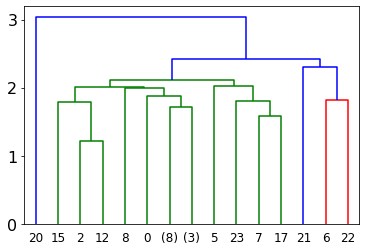

In [93]:
scores=scenarios_regr
hier_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(scores.values)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(hier_clust, truncate_mode='level', p=6)

0.420 --> 0.365 --> 0.365 --> 
Profile cardinality [%]: 0.03


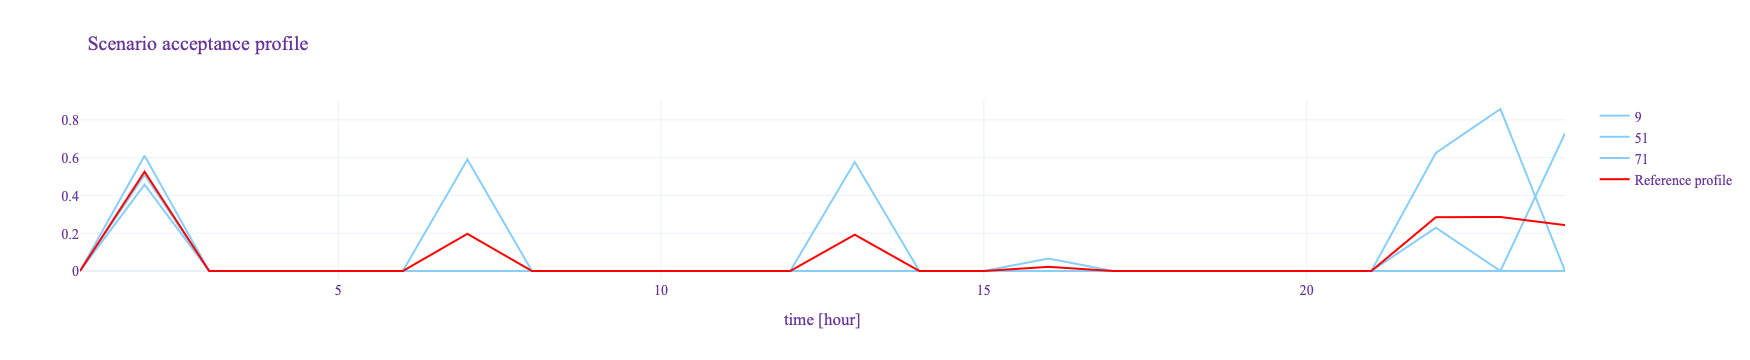

Profile cardinality [%]: 0.97


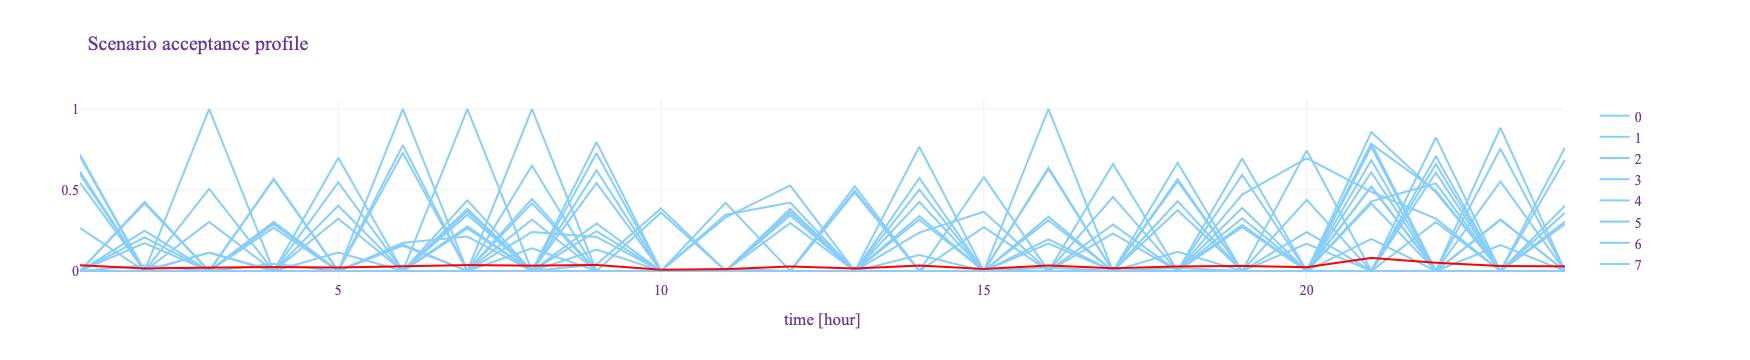

In [180]:
n_clust=2
scenarios_regr_trans=scenarios_regr.transpose()
km = TimeSeriesKMeans(n_clusters=n_clust, verbose=True, random_state=42)
profiles = km.fit_predict(scenarios_regr_trans)

for sel in range(0,n_clust):
    prof=scenarios_regr_trans[profiles==sel]
    fig=go.Figure()
    print(f'Profile cardinality [%]: {len(prof)/len(scenarios_regr_trans)}')
    for idx in range(0,len(prof.index)):
        fig.add_trace(go.Scatter(x=scenarios_regr.index+1,y=prof.iloc[idx], name=str(prof.index[idx]),marker=dict(color='LightSkyBlue')))
    fig.add_trace(go.Scatter(x=scenarios_regr.index+1,y=km.cluster_centers_[sel].ravel(), name='Reference profile',marker=dict(color='red')))
    fig.update_layout(title="Scenario acceptance profile",
                      xaxis_title="time [hour]",
                      font=dict(family="Times New Roman, monospace",size=14,color="RebeccaPurple"),
                      template="plotly_white")
    fig.show()



In [94]:


# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

C:\Users\Anaconda\lib\site-packages\plotly\graph_objs\_deprecations.py:441: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


C:\Users\Anaconda\lib\site-packages\plotly\graph_objs\_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: ['texttemplate', 'uirevision', 'customdata', 'error_y', 'visible', 'orientation', 'dy', 'y', 'connectgaps', 'hovertext']

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])